In [1]:
#librerias

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, UpSampling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import random
from shutil import copyfile
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras import backend

/home/airamariza/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
tf.keras.backend.clear_session()
DIRECTORY = r"/home/airamariza/Cosas/proyectos/mask_pro/data"

try:
    os.mkdir("/home/airamariza/Cosas/proyectos/mask_pro/mask_no_mask")
    os.mkdir("/home/airamariza/Cosas/proyectos/mask_pro/mask_no_mask/training")
    os.mkdir("/home/airamariza/Cosas/proyectos/mask_pro/mask_no_mask/testing")
    os.mkdir("/home/airamariza/Cosas/proyectos/mask_pro/mask_no_mask/training/wm")
    os.mkdir("/home/airamariza/Cosas/proyectos/mask_pro/mask_no_mask/testing/wm")
    os.mkdir("/home/airamariza/Cosas/proyectos/mask_pro/mask_no_mask/training/nm")
    os.mkdir("/home/airamariza/Cosas/proyectos/mask_pro/mask_no_mask/testing/nm")

except OSError:
    pass

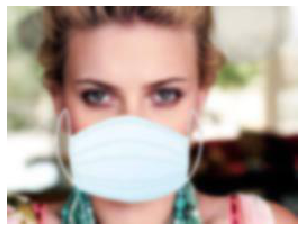

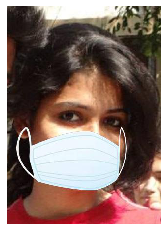

In [3]:
#images with mask
directorio_m = os.listdir("/home/airamariza/Cosas/proyectos/mask_pro/data/with_mask/")
for images in directorio_m[0:2]:
    fotos = os.path.join("/home/airamariza/Cosas/proyectos/mask_pro/data/with_mask", images)
    image = plt.imread(fotos)
    plt.axis("off")
    plt.imshow(image)
    plt.show()

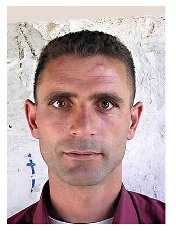

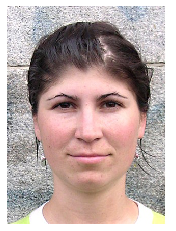

In [17]:
directorio_sm = os.listdir("/home/airamariza/Cosas/proyectos/mask_pro/data/without_mask/")
for images in directorio_sm[0:2]:
    fotos = os.path.join("/home/airamariza/Cosas/proyectos/mask_pro/data/without_mask", images)
    image = plt.imread(fotos)
    plt.axis("off")
    plt.imshow(image)
    plt.show()

In [18]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    
    images = []
    for imagename in os.listdir(SOURCE):
        
        image = SOURCE + imagename
        
        if os.path.getsize(image) > 0:
            
            images.append(imagename)
        else:
            print(imagename + "No será selecionada")
            
    training_size = int(SPLIT_SIZE * len(images))
    shuffled_data = random.sample(images, len(images))
    training_data = shuffled_data[:training_size]
    testing_data = shuffled_data[training_size:]
    
    for image in training_data:
        
        origin = SOURCE + image
        destination = TRAINING + image
        copyfile(origin, destination)
    
    for image in testing_data:
        
        origin2 = SOURCE + image
        destination2 = TESTING + image
        copyfile(origin2, destination2)        
        
        

In [19]:
with_mask_training_dir = "/home/airamariza/Cosas/proyectos/mask_pro/mask_no_mask/training/wm/"
with_mask_testing_dir = "/home/airamariza/Cosas/proyectos/mask_pro/mask_no_mask/testing/wm/"
no_mask_training_dir = "/home/airamariza/Cosas/proyectos/mask_pro/mask_no_mask/training/nm/"
no_mask_testing_dir = "/home/airamariza/Cosas/proyectos/mask_pro/mask_no_mask/testing/nm/"

#with mask
split_data("/home/airamariza/Cosas/proyectos/mask_pro/data/with_mask/",
          with_mask_training_dir,
          with_mask_testing_dir,
          0.9)
#no mask
split_data("/home/airamariza/Cosas/proyectos/mask_pro/data/without_mask/",
          no_mask_training_dir,
          no_mask_testing_dir,
          0.9)

In [20]:

print("Number of without_mask images for training:",len(os.listdir(no_mask_training_dir)))
print("Number of without_mask images for testing:", len(os.listdir(no_mask_testing_dir)))
print("Number of with_mask images for training:", len(os.listdir(with_mask_training_dir)))
print("Number of with_mask images for testing:", len(os.listdir(with_mask_testing_dir)))

Number of without_mask images for training: 688
Number of without_mask images for testing: 288
Number of with_mask images for training: 690
Number of with_mask images for testing: 286


In [21]:
#data augmentation
TRAINING_DIR = "/home/airamariza/Cosas/proyectos/mask_pro/mask_no_mask/training/"
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    target_size=(224, 224))


TESTING_DIR = "/home/airamariza/Cosas/proyectos/mask_pro/mask_no_mask/testing/"

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(TESTING_DIR,
                                                 batch_size = 32,
                                                 class_mode = "binary",
                                                 target_size = (224,224))


Found 1378 images belonging to 2 classes.
Found 574 images belonging to 2 classes.


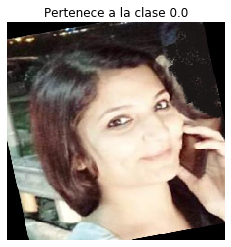

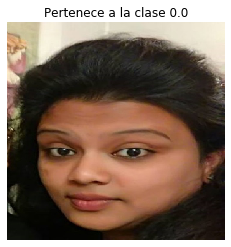

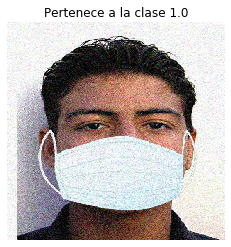

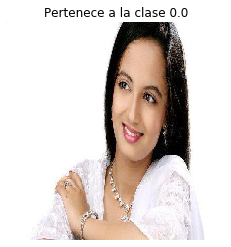

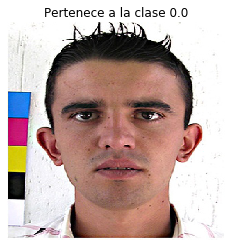

In [25]:
batch = test_generator.next()
for i in range(len(batch[0][0:5])):
    img_array = batch[0][i] 
    img = tf.keras.utils.array_to_img(img_array)
    plt.title("Pertenece a la clase " + str(batch[1][i]))
    plt.axis("off")
    plt.imshow(img)
    plt.show()

In [29]:
#model development

def feature_extractor(inputs):
    
    mobilenet = MobileNetV2(input_shape = (224,224,3), weights = "imagenet",
                     include_top = False)(inputs)
    mobilenet.trainable = False
    return mobilenet

def classifier(input):
    
    x = Flatten()(input)
    x = Dense(512, activation = "relu")(x)
    x = Dropout(0.25)(x)
    x = Dense(1024, activation = "relu")(x)
    x = Dropout(0.25)(x)
    x = Dense(1, activation = "sigmoid", name = "classification")(x)
    return x

def final_model(inputs):
    mobilenet = feature_extractor(inputs)
    classifier_output = classifier(mobilenet)
    return classifier_output

def define_compile_model():
    opt = Adam(learning_rate = 1e-4)
    model_input = Input(shape = (224,224,3))
    classifier_output = final_model(model_input)
    model = Model(inputs = model_input, outputs = classifier_output)
    model.compile(loss = "binary_crossentropy", optimizer = opt,
                 metrics = "accuracy")
    return model


model = define_compile_model()
    

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 512)               32113152  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                             

In [31]:
EPOCHS = 10

history = model.fit(
        train_generator, epochs = EPOCHS,
        verbose = 1, validation_data = test_generator
)

Epoch 1/10
44/44 [==============================] - 58s 1s/step - loss: 0.2765 - accuracy: 0.8832 - val_loss: 0.0139 - val_accuracy: 0.9913
Epoch 2/10
44/44 [==============================] - 63s 1s/step - loss: 0.0564 - accuracy: 0.9775 - val_loss: 0.0817 - val_accuracy: 0.9808
Epoch 3/10
44/44 [==============================] - 61s 1s/step - loss: 0.0663 - accuracy: 0.9811 - val_loss: 0.1263 - val_accuracy: 0.9739
Epoch 4/10
44/44 [==============================] - 61s 1s/step - loss: 0.0206 - accuracy: 0.9927 - val_loss: 0.1074 - val_accuracy: 0.9826
Epoch 5/10
44/44 [==============================] - 61s 1s/step - loss: 0.0119 - accuracy: 0.9949 - val_loss: 0.0715 - val_accuracy: 0.9861
Epoch 6/10
44/44 [==============================] - 61s 1s/step - loss: 0.0199 - accuracy: 0.9956 - val_loss: 0.0576 - val_accuracy: 0.9895
Epoch 7/10
44/44 [==============================] - 61s 1s/step - loss: 0.0125 - accuracy: 0.9971 - val_loss: 0.0562 - val_accuracy: 0.9843
Epoch 8/10
44/44 [==

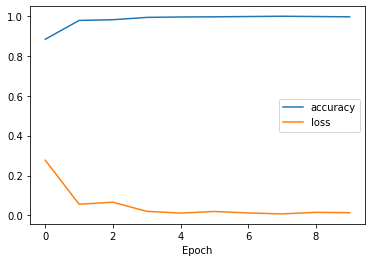

In [35]:
plt.plot(history.history["accuracy"], label = "accuracy")
plt.plot(history.history["loss"], label = "loss")
plt.xlabel('Epoch')
plt.legend()

In [36]:
model.save("mask_detector_model.model", save_format = "h5")